# Monte Carlo Dropout - Uncertainty Estimation

In [1]:
import os

# move to root dir
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# torch
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn as nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import models, transforms

# local helpers
from data.dataframe import dataframe_from_dir
from data.dataloader import HAM10000
from model.train import Experiment

# monte-carlo
from model.monte_carlo import add_dropout_layers
from model.monte_carlo import predict

# to make the results are reproducible
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set plt theme
sns.set_theme()

ImportError: cannot import name 'df_train_val' from 'data.dataframe' (/home/moritz/dev/ham_10000/data/dataframe.py)

## Params

In [2]:
augmented_data = True

conv_drop = True
final_drop = True

device = torch.device("cuda:0")

## Data

In [5]:
input_dir       = "input/aug/" if augmented_data else "input/orga"
dfs             = {x: dataframe_from_dir(f'{input_dir}/{x}')
                   for x in ['train', 'val']}
dataset_sizes   = {x: len(dfs[x]) for x in ['train', 'val']}


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

if augmented_data: data_transforms = {'train': None, 'val': None}

dataloaders = {x: DataLoader(HAM10000(f"{input_dir}/{x}", data_transforms[x]),
                batch_size=32, shuffle=(x=='train'), num_workers=2)
                for x in ['train', 'val']}

num_classes = len(dfs['train']['y'].unique())

## Models

### Train models

In [5]:
xps = []

In [7]:
model = models.resnet50(pretrained=True)
comment = "rn50"

num_ftrs = model.fc.in_features

if final_drop:
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(num_ftrs, num_classes))
    comment += "-final_drop"
else:
    model.fc = nn.Linear(num_ftrs, num_classes)

if conv_drop:
    add_dropout_layers(model, base_rate=0.1)  # add dropout
    comment += "-conv_drop"
model = model.to(device)

if augmented_data: comment += "-aug"

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


if not glob(f"output/{comment}"):
    xps += [Experiment(model, criterion, optimizer, scheduler,
                       dataloaders, dataset_sizes,
                       num_epochs=20, comment=comment)]
else:
    print(f'Experiment already exists ({comment})')

Experiment already exists (rn50-final_drop-conv_drop-aug)


In [7]:
for experiment in xps:
    experiment.train_model()

### Load checkpoint

In [8]:
!ls output/

 checkpoints   rn50-final_drop       rn50-final_drop-conv_drop-aug
 logs          rn50-final_drop-aug  


In [19]:
# load checkpoint
checkpoint = torch.load(f"output/{comment}/best_model.pt")

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

## Predict

In [24]:
cols   = dfs['train']['cell_type'].factorize(sort=True)[1]

def plot_prediction(y_pred, y_true):
    y_pred = y_pred.cpu().detach().numpy()
    df_    = pd.DataFrame(y_pred, columns=cols)

    plt.title(f'Single shot prediction [Y true = {cols[y_true]}]')
    plt.xlabel("Cancer")
    plt.ylabel("Probabilty")
    sns.barplot(data=df_)
    plt.show()
    

def plot_mcd_pred(y_preds, y_true=None):
    df_    = pd.DataFrame(np.array(preds), columns=cols)
    
    plt.title(f'Monte Carlo prediction [Y true = {cols[y_true]}]')
    plt.xlabel("Cancer")
    plt.ylabel("Probabilty")
    sns.boxplot(data=df_, showfliers=False)
    plt.show()

In [26]:
sample_image = None
for test_images, test_labels in dataloaders['val']:
#for test_images, test_labels in dataloader_val:
    for i, sample_label in enumerate(test_labels):
        # dont pick most common class sample
        if sample_label == dfs['train']['y'].value_counts().keys()[0]: 
            continue

        # dont pick same always
        if np.random.rand() > 0.9:
            sample_image = test_images[i]
            break
    if sample_image is not None: break
    
X      = sample_image.unsqueeze(0)
X      = X.to(device)
y_true = sample_label.item()

print(sample_label)

tensor(0)


In [32]:
X.shape

torch.Size([1, 3, 224, 224])

### Default

In [27]:
y_pred = predict(model, X, dropout=False)
y_pred = F.softmax(y_pred, 1)
plot_prediction(y_pred, y_true)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

### Monte Carlo

In [176]:
sns.set_theme()

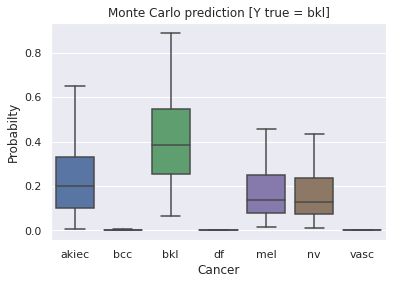

In [177]:
T = 100
preds = []
for _ in range(T):
    pred   = predict(model, X, dropout=True)
    pred   = F.softmax(pred, dim=1)
    preds += [pred.cpu().detach().numpy()[0]]

plot_mcd_pred(preds, y_true)